<table class="table table-bordered">
    <tr>
        <th style="text-align:center; width:25%"><img src='https://www.np.edu.sg/PublishingImages/Pages/default/odp/ICT.jpg' style="width: 250px; height: 125px; "></th>
        <th style="text-align:center;"><h1>Deep Learning</h1><h2>Assignment 2 - Sentiment Analysis Model (Problem 1)</h2><h3>AY2020/21 Semester</h3></th>
    </tr>
</table>

Objective: Build a sentiment analysis model to predict the emoticon for each text input. 


In [1]:
DATA_DIR = "../data"

In [2]:
# Import the Required Packages
import os
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from zipfile import ZipFile

Configure access to MLFlow by setting the following environment variables:
- `MLFLOW_TRACKING_URI` - URL to the MLFlow Tracking server.
- `MLFLOW_S3_ENDPOINT_URL` - URL to the MLFlow S3 Backend Store.


In [3]:
%env MLFLOW_TRACKING_URI

'http://mlflow.mlflow.svc.cluster.local:5000'

In [4]:
%env MLFLOW_S3_ENDPOINT_URL

'http://minio.minio.svc.cluster.local:9000'

`TF_FORCE_GPU_ALLOW_GROWTH` -  Force Tensorflow to allocate GPU memory dynamically
instead of of all at once as a workaround for this
[cuDNN failed to initialize issue](https://github.com/tensorflow/tensorflow/issues/24828).

In [5]:
%env TF_FORCE_GPU_ALLOW_GROWTH=true

env: TF_FORCE_GPU_ALLOW_GROWTH=true


# Step 1 – Data Loading and Processing

### 1.1 Data Loading

In [6]:
# Load the emoji_dictionary
df = pd.read_csv(f"{DATA_DIR}/mapping.csv", delimiter=',')
emoji_dictionary = df.loc[:,'emoticons'].to_dict()
print(emoji_dictionary)
print('A total of: ', len(emoji_dictionary), 'Emoji Icons')

{0: '😍', 1: '😂', 2: '📷', 3: '🔥', 4: '❤'}
A total of:  5 Emoji Icons


Since the emojis can't be rendered in some situations such as graph plotting, create a mapping for the labels to emoji nameategorical types for the grouping variables to control the order of plot elements.

In [7]:
emoji_names = {
    0: "heart-eyes",
    1: "crying-laughing",
    2: "camera",
    3: "fire",
    4: "heart",
}

In [8]:
# load the dataset
df = pd.read_csv(f"{DATA_DIR}/dataset.csv", delimiter=',')
texts = df.loc[:,'TEXT'].values 
labels = df.loc[:,'Label'].values

In [9]:
# Check the maximum length of texts
max_len = -1
for example in texts:
    if len(example.split()) > max_len:
        max_len = len(example.split())
        
print('the maximum length of the text inputs is ', max_len)

the maximum length of the text inputs is  34


### 1.2 EDA

View the first 5 rows of data:

In [10]:
df.head()

,TEXT,Label
0,Been friends since 7th grade. Look at us now w...,0
1,This is what it looks like when someone loves ...,1
2,RT @user this white family was invited to a Bl...,1
3,"Westenders @user #LAZzNation @ Weston, Toronto\n",2
4,Maxwell heads home @ Summa Akron City Hospital\n,0


Splice in actual emojis and names to make the data easier to grasp than raw number labels:

In [11]:
df["Emoji"] = df["Label"].map(emoji_dictionary)
df["EmojiName"] = df["Label"].map(emoji_names)
df.head()

,TEXT,Label,Emoji,EmojiName
0,Been friends since 7th grade. Look at us now w...,0,😍,heart-eyes
1,This is what it looks like when someone loves ...,1,😂,crying-laughing
2,RT @user this white family was invited to a Bl...,1,😂,crying-laughing
3,"Westenders @user #LAZzNation @ Weston, Toronto\n",2,📷,camera
4,Maxwell heads home @ Summa Akron City Hospital\n,0,😍,heart-eyes


Visualise the distribution of the data examples for each Emoji to check for class imbalance:


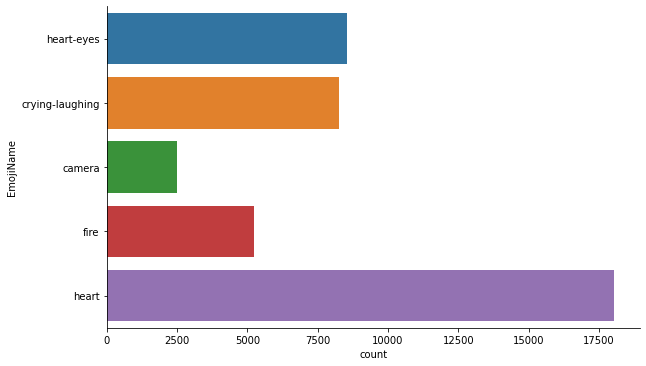

In [12]:
sns.catplot(kind="count", data=df, y="EmojiName", aspect=16/9)

In [13]:
df["Emoji"].value_counts()

❤    18043
😍     8537
😂     8247
🔥     5223
📷     2496
Name: Emoji, dtype: int64

Observations:
- The disparty between the number of examples between the different Emojis show a significant class imbalance.
- Metrics such as accuracy will not produce accurate results until the class imbalance issue is resolved. [[1]](https://machinelearningmastery.com/failure-of-accuracy-for-imbalanced-class-distributions/)

Glancing through the data examples, one can make the following observations about the data:
- Although there are no Emojis used in the data, emoticons such as `:)` or `:(` are present in the text data.
- Common contractions ie `w/` to represent `with` are present in the text data.
- Stylised words such as `O B E S S E D` will need to be converted its normal `obsessed` equavilent
- Location words seem highly indicative that the class should be a 📷  

### 1.2 Data Processing


Cleaning text data [2](https://www.kaggle.com/sudalairajkumar/getting-started-with-text-preprocessing):
- `lower_case` - Convert all text tokens to lower case so that `Happy` and `happy` will appear the same to the model.
- `remove_punc` - Remove punctuations such that `yes!` and `yes` would appear the same to model. Mutually exclusive with `tokenize_punc`.
- `tokenize_punc` - Separate puntcuations from words to become separate tokens. `no?` becomes `no` and `?`. Mutually exclusive with `remove_punc`. 
- `stopwords` - Removal of stopwords: meaningless words such as `the`, `a`, that are likely irrelevant to prediction.
- `replace_emot` - Replace emoticons such `:)` with their textual equvilent `happy`.
- `stemming` - Remove inflections from words (ie jump**ing**, jump**ed**, jump**s**,) by steming them.
- `lemmatization` - Remove inflections from words by looking up the word's lemma.
- `replace_abbv` - Replace common abbreviations and contractions by looking up their full words.

In [14]:
# TODO: implement

Converting text into vectors:
- `one_hot` - one hot encoding of the word vector data, acts as baseline.
- `fasttext_pretrained` - pretrained fasttext vectors
- `fasttext` - fastext vectors trained on our dataset.
- `doc2vec`- doc2vec vectors trained on our dataset.
- `doc2vec_preatrained`- doc2vec pretrained vectors.
- `lexvec` - LexVec vectors trained on our dataset.
- `lexvec_pretrained` - LexVec retrained vectors.

> Out of interests of time, `word2vec` is not included as`word2vec` vectors are significantly worst as compared to `fasttext` [[3]](https://github.com/RaRe-Technologies/gensim/blob/ba1ce894a5192fc493a865c535202695bb3c0424/docs/notebooks/Word2Vec_FastText_Comparison.ipynb)

In [15]:
# Convert the texts and labels into numeric tensors

### 1.3 Data Sampling

To combat the class imbalance issue we have a couple of options:
- `oversample` : Use Random Oversampling to duplicate the data examples for Emojis smaller no. of examples to match the majority class.
- `undersample`: Use Random Undersampling to undersample the data examples for the Majority Emoji cass to match the minority class.
- `SMOTE`: Interpolate new systhesised training examples
- TODO: continue

In [16]:
# Split the X & y into train and test sets
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


## Step 2 – Develop a Sentiment Analysis Model

### Model #1

In [17]:
# Build the Model


In [18]:
# Train the Model


In [19]:
# Plot the Training and Validation Accuracy & Loss Scores


In [20]:
# Save the Model
#model.save('text_model_1.h5')

### Model #2

In [21]:
# Build the Model


In [22]:
# Train the Model


In [23]:
# Plot the Training and Validation Accuracy & Loss Scores


In [24]:
# Save the Model
#model.save('text_model_2.h5')

## Step 3 – Evaluate the Model using Testing Data 

In [25]:
# Model #1 (replicate where necessary for other models)
#model.load_weights('text_model_1.h5')


In [26]:
# Save the Best Model
#model.save('text_model_best.h5')

## Step 4 – Use the Best Model to make prediction

In [27]:
#model.load_weights('text_model_best.h5')

In [28]:
# takes the user input
#text_input = np.array([input()])

In [29]:
# convert the user input into numeric tensor


In [30]:
# show the model output using predict function


# References
- [1] Failure of Classification Accuracy for Imbalanced Class Distributions. (2021, January 21). Retrieved from https://machinelearningmastery.com/failure-of-accuracy-for-imbalanced-class-distributions  
- [2] sudalairajkumar. (2019). Getting started with Text Preprocessing. Kaggle. Retrieved from https://www.kaggle.com/sudalairajkumar/getting-started-with-text-preprocessing
- [3] RaRe-Technologies. (2021, January 28). gensim. Retrieved from https://github.com/RaRe-Technologies/gensim/blob/ba1ce894a5192fc493a865c535202695bb3c0424/docs/notebooks/Word2Vec_FastText_Comparison.ipynb